In [2]:
%load_ext autoreload
%autoreload 2

In [155]:
import re
import numpy as np
def has_only_letters_and_space(text):
    stop_symbols = '()|$&*#!/-'
    for s in stop_symbols:
        text = text.replace(s,' ')
    
    text = text.strip()
    
    pattern = r'^[A-Za-z\s]+$'
    return re.match(pattern, text) is not None

def filter_words_boxes(G):
    nodes_to_remove = []
    for node in G:
        w = G.nodes[node]['text'].lower()
        w = w.lower()
        #w = ''.join([char for char in w if not char.isdigit()])
        
        if not has_only_letters_and_space(w):
            nodes_to_remove.append(node)
            continue
        
        w = w.strip()
        #if len(w) == len(''.join([i for i in w if not i.isdigit()])):
        
        if len(w)<=3:
            nodes_to_remove.append(node)
            continue
            
        if len(w.split(' '))>=4:
            nodes_to_remove.append(node)
            
    if nodes_to_remove:
        G.remove_nodes_from(nodes_to_remove)
                

def text_similarity(words1,words2):
    """Calculate the similarity between two sets of words based on the Jaccard index."""
    
    words1_set = set(words1)
    words2_set = set(words2)
     
    shared = words1_set & words2_set
    union = words1_set | words2_set
    
    if not union:
        return shared, union, 0

    similarity = round(len(shared) / len(union), 2)
    
    return shared, union, similarity


def images_similarity(source_G,target_G, pairwise_distance, threshold=5):
    """Calculate the similarity between two images based on the number of matched boxes."""

    found_boxes = []
    for ix in range(len(source_G)):
        matched_box = find_target_node_by_text(ix, 
                            source_G,
                            target_G,
                            pairwise_distance,
                            threshold=threshold
                            )
            
        if matched_box is not None:
            found_boxes.append(matched_box)
    
    if not found_boxes:
        return 0, 0
    
    num_found_boxes = len(found_boxes)

    return num_found_boxes, round(2*num_found_boxes/(len(source_G)+len(target_G)),2)

In [65]:
from sentence_transformers import SentenceTransformer, util
text_embedder_core = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
def text_to_embedding(text):
    #if find_word(text) or find_words(text):
    return text_embedder_core.encode(text, convert_to_tensor=False)

In [104]:
from doc2graph.src.data.image_utils import get_word_boxes, draw_graph, file_to_images
from doc2graph.src.data.graph_utils import create_graph, calc_text_embedding, Conv, features_dist, find_target_node_by_text
from doc2graph.src.data.find_items import text_to_mask

from sklearn.metrics import pairwise_distances


In [51]:
source_file = "data/b2f42472-7b07-44ed-9ef7-e7cb49b6b643.jpeg"
source_word_boxes = get_word_boxes(source_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')

In [52]:
target_file = "data/1685484224508_0455103c-074a-42c5-bc05-aa534505d658_RecordtransferACH052623.pdf"
target_word_boxes = get_word_boxes(target_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')

In [53]:
source_image = file_to_images(source_file)[0]
target_image = file_to_images(target_file)[0]

In [88]:
source_graph = create_graph(source_word_boxes['words'], source_word_boxes['boxes'])
target_graph = create_graph(target_word_boxes['words'], target_word_boxes['boxes'])

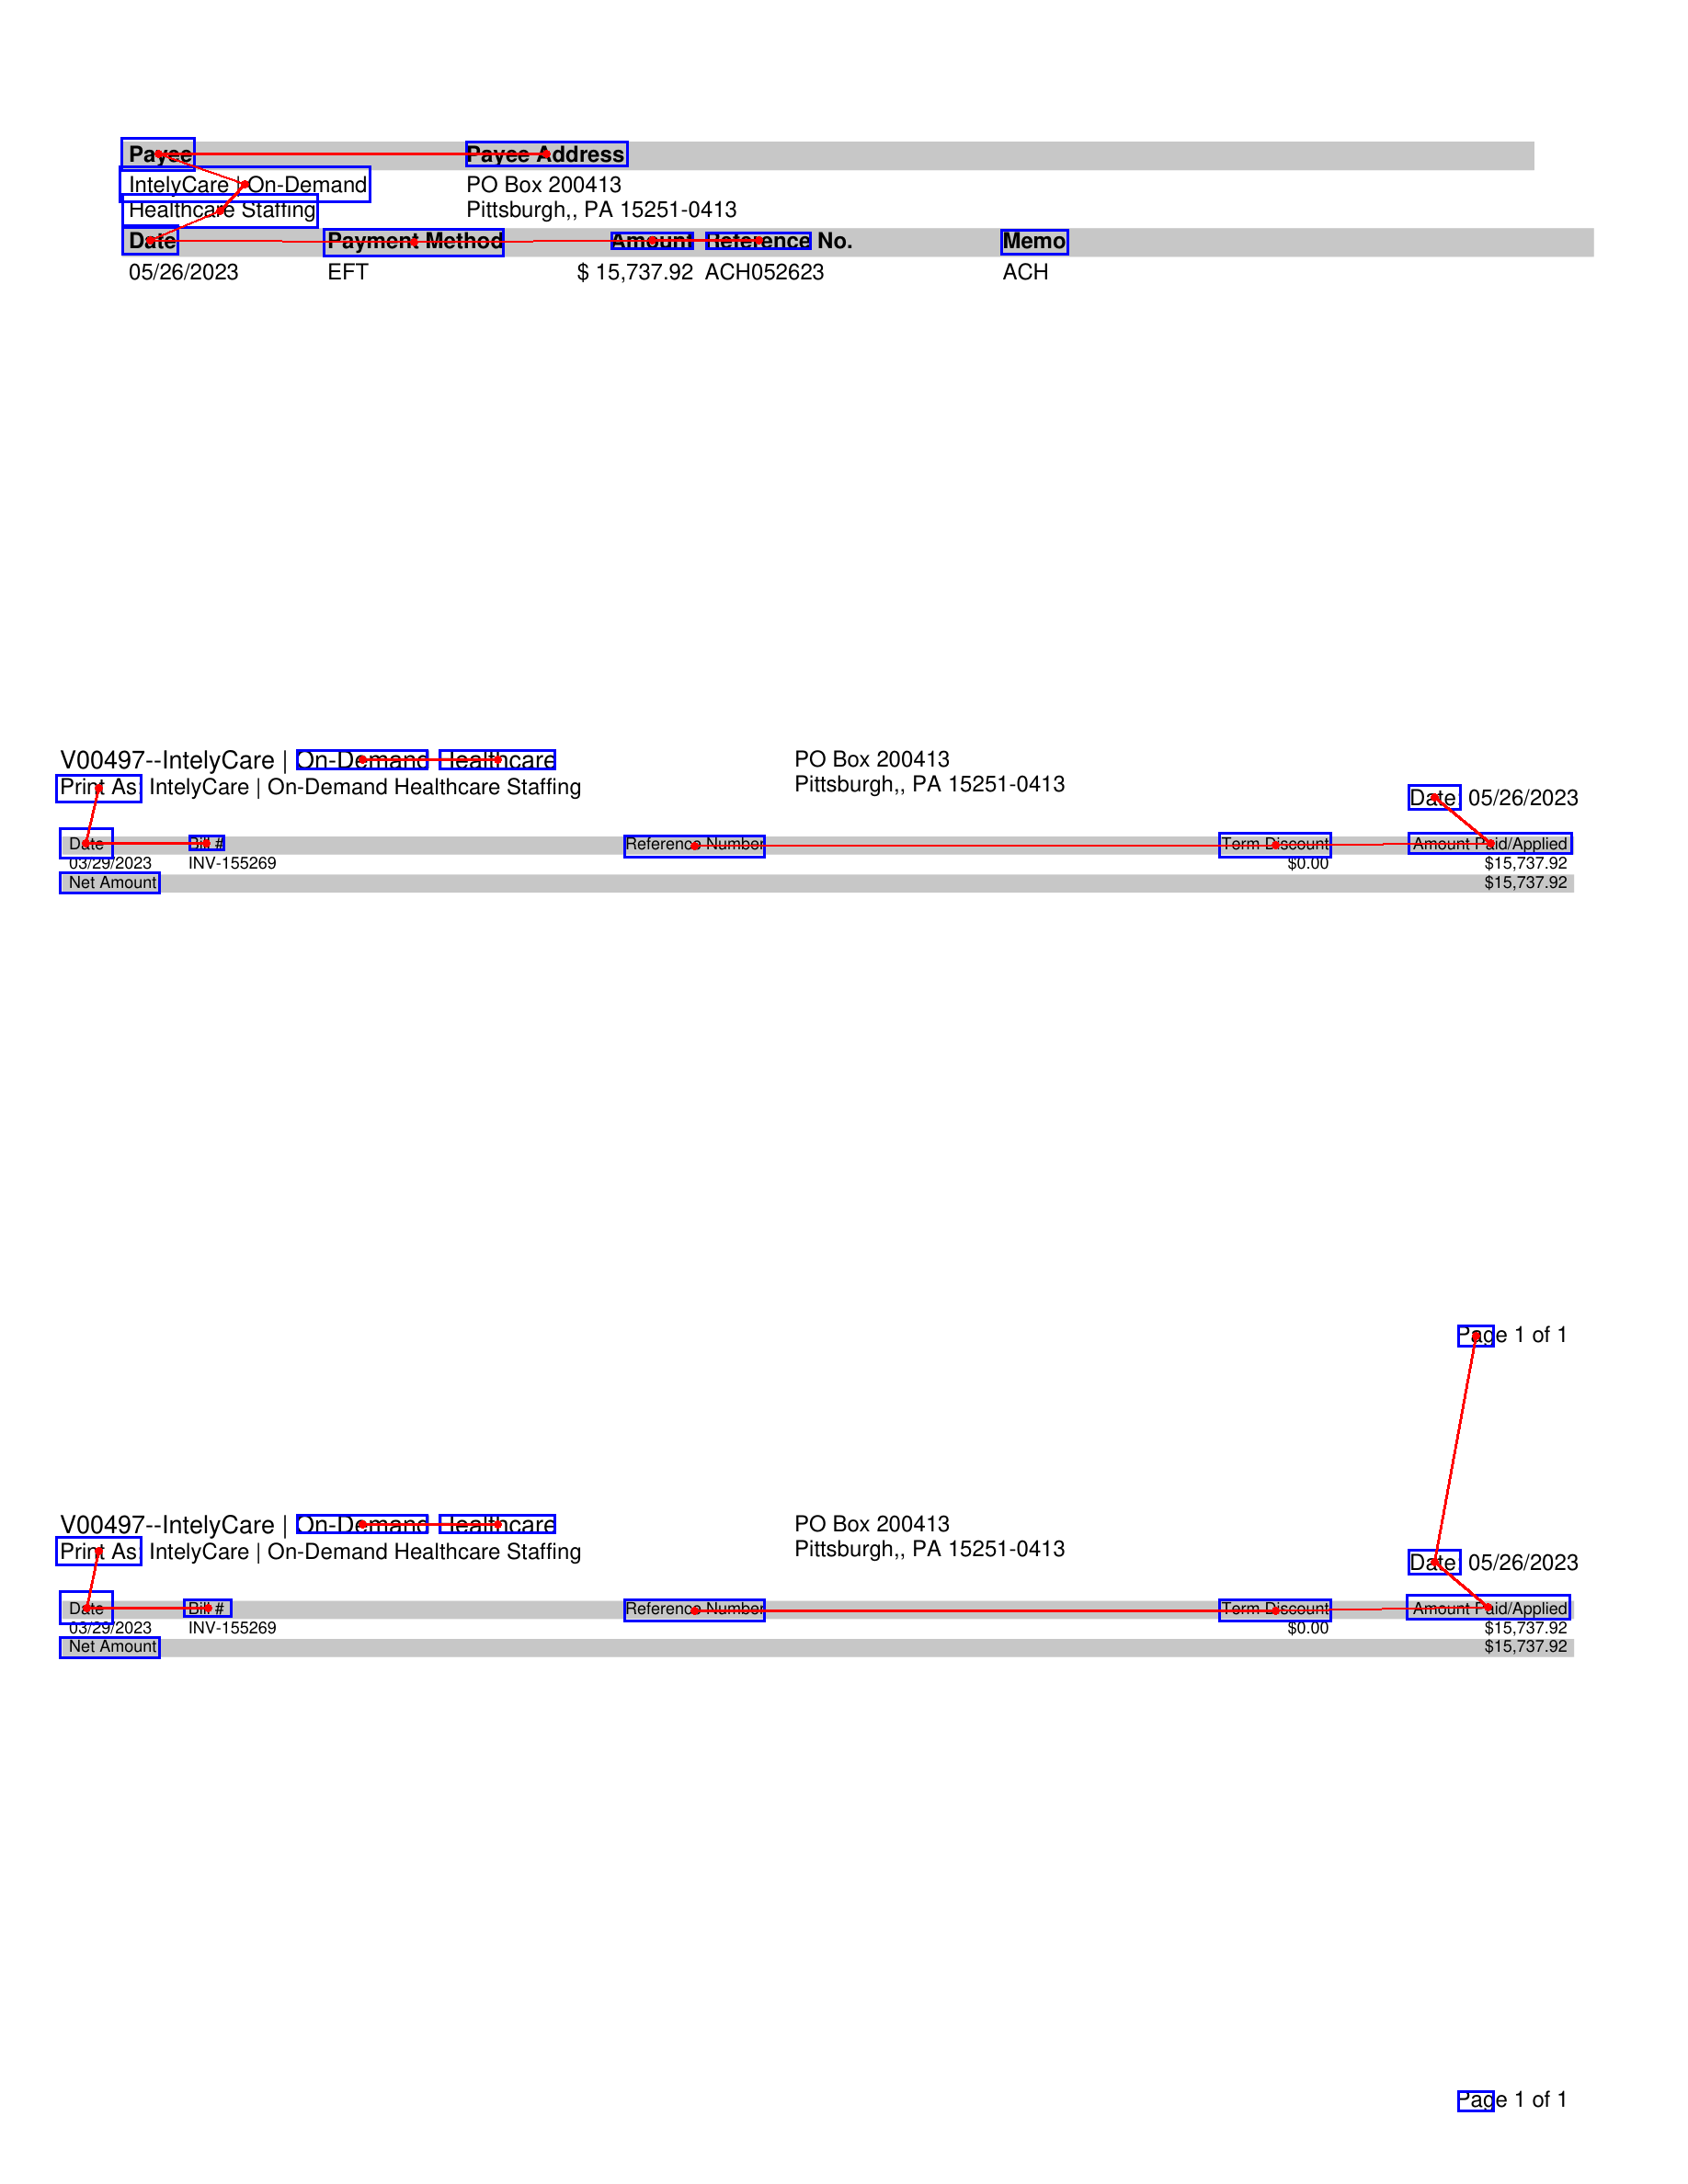

In [94]:
im_c = target_image.copy()
draw_graph(im_c, target_graph,nodes=None)
im_c

In [89]:
calc_text_embedding(source_graph, text_to_embedding, text_to_mask)
calc_text_embedding(target_graph, text_to_embedding, text_to_mask)

In [90]:
Conv(source_graph)
Conv(target_graph)

In [91]:
filter_words_boxes(source_graph)
filter_words_boxes(target_graph)

In [117]:
source_words_filtered = [source_graph.nodes[node]['text'] for node in source_graph]
target_words_filtered = [target_graph.nodes[node]['text'] for node in target_graph]
shared_words, _, text_similarity_score = text_similarity(source_words_filtered, target_words_filtered)
text_similarity_score     

0.31

In [118]:
source_embeddings_filtered = [source_graph.nodes[node]['conv_embedding'] for node in source_graph]
target_embeddings_filtered = [target_graph.nodes[node]['conv_embedding'] for node in target_graph]
pairwise_dist = pairwise_distances(source_embeddings_filtered, target_embeddings_filtered, metric = features_dist)

In [158]:
images_similarity_count, images_similarity_score = images_similarity(source_graph,target_graph, pairwise_dist, threshold=6)

Text not match: Insight -> Memo 0.0 5.191228294372559
Text not match: Insight -> Memo 0.0 5.185676574707031
Text not match: Non-negotiable -> Term Discount 0.2222222222222222 5.90637378692627
Text not match: MWEC -> Memo 0.25 5.426461315155029
GRAPH Print As ---> Print As 3.141791343688965
Text not match: Insight -> Memo 0.0 5.2397863388061525
GRAPH Date ---> Date 1.7168939590454102
GRAPH Date ---> Date 2.1454124450683594
GRAPH Bill # ---> Bill # 2.416170883178711
GRAPH Reference Number ---> Reference Number 1.6024717330932619
GRAPH Amount Paid/Applied ---> Amount Paid/Applied 1.5788331985473634
GRAPH Net Amount ---> Net Amount 1.0785001754760744
GRAPH Page ---> Page 0.8361513137817383
Text not match: MWEC -> Memo 0.25 5.426461315155029
GRAPH Print As ---> Print As 3.141791343688965
Text not match: Insight -> Memo 0.0 5.2397863388061525
GRAPH Date ---> Date 1.5518836975097656
GRAPH Date ---> Date 2.1368432998657227
GRAPH Bill# ---> Bill# 2.434789848327637
GRAPH Reference Number ---> Re

In [159]:
{
    'images_similarity_score': images_similarity_score,
    'images_similarity_count': images_similarity_count,
    'text_similarity_score': text_similarity_score
}

{'images_similarity_score': 0.52,
 'images_similarity_count': 16,
 'text_similarity_score': 0.31}